In [1]:
import cv2
import os
import torch
from PIL import Image
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torchvision import transforms as torchvision_transforms
from segmentation_models_pytorch import Unet
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks
from src.dataset import EyeDataset, DatasetPart, InferenceDataset
from src.metrics import make_metrics, make_criterion, make_bce_dice_criterion
from src.trainer import UnetTrainer
from src.utils import plot_history
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

STAGE 0 - чистка от плохих данных

In [3]:
base_size = 1624, 1232
path = 'ds/train/'
for file in list(os.listdir(path)):
    if ' ' in file:
        os.rename(path + file, path + file.replace(' ', ''))

for file in list(os.listdir(path)):
    if file.endswith('png'):
        if not os.path.exists(path + file.replace('.png', '.geojson')):
            os.remove(path + file)
        try:
            img = Image.open(path + file)
            if img.size != base_size:
                os.remove(path + file)
        except:
            os.remove(path + file)
        break

    elif file.endswith('geojson'):
        if not os.path.exists(path + file.replace('.geojson', '.png')):
            os.remove(path + file)
    else:
        os.remove(path + file)

STAGE 1
Первый этап обучения на изображениях 512х512

In [3]:
# Набор аугментаций и трансофрмаций для тренировочного и валидационного датасетов
size = 512
train_list = [
        alb.LongestMaxSize(size, interpolation=cv2.INTER_AREA),
        alb.PadIfNeeded(size, size),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        ToTensorV2(transpose_mask=True),
    ]
eval_list = [
        alb.LongestMaxSize(size, interpolation=cv2.INTER_AREA),
        alb.PadIfNeeded(size, size),
        ToTensorV2(transpose_mask=True)
    ]

transforms = {'train': alb.Compose(train_list), 'test': alb.Compose(eval_list)}
dataset = EyeDataset("ds/train")
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25, random_state=42)
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    25,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    25,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

In [6]:
# Создание модели и тренера
model = Unet('timm-resnest50d', activation='logsoftmax', classes=2).cuda()
criterion = make_criterion()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())

In [7]:
# 1й этап обучения
summary = trainer.fit(train_loader, 20, val_loader=valid_loader)
torch.save(model, 'models/stage1.pth')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

loss_train: 0.9697179982536718
dice_train: 0.030281999491547282
accuracy_train: 0.015421536309938682
recall_train: 0.8419448137283325
--------


  5%|████                                                                            | 1/20 [03:21<1:03:40, 201.08s/it]

loss_test: 0.9742122093836466
dice_test: 0.025787796825170517
accuracy_test: 0.01307845457146565
recall_test: 0.9352220495541891
--------
loss_train: 0.9548835848507128
dice_train: 0.045116412698438295
accuracy_train: 0.023099694499059728
recall_train: 0.9742196421874197
--------


 10%|████████▏                                                                         | 2/20 [06:36<59:18, 197.72s/it]

loss_test: 0.9453552961349487
dice_test: 0.05464470821122328
accuracy_test: 0.028129492265482742
recall_test: 0.9593100647131602
--------
loss_train: 0.9414963377149481
dice_train: 0.058503665226070506
accuracy_train: 0.030189385931742817
recall_train: 0.9627808614781028
--------


 15%|████████████▎                                                                     | 3/20 [09:53<55:58, 197.54s/it]

loss_test: 0.9221688111623129
dice_test: 0.07783118759592374
accuracy_test: 0.040658801794052124
recall_test: 0.9126213490962982
--------
loss_train: 0.9281150698661804
dice_train: 0.07188493778046809
accuracy_train: 0.03738181998855189
recall_train: 0.9480912246202168
--------


 20%|████████████████▍                                                                 | 4/20 [13:09<52:27, 196.75s/it]

loss_test: 0.9121066629886627
dice_test: 0.08789334446191788
accuracy_test: 0.04629780041674773
recall_test: 0.8768869737784067
--------
loss_train: 0.9128777949433577
dice_train: 0.0871222062330497
accuracy_train: 0.04578080126329472
recall_train: 0.9227350667903298
--------


 25%|████████████████████▌                                                             | 5/20 [16:20<48:39, 194.65s/it]

loss_test: 0.8942929406960806
dice_test: 0.10570705806215604
accuracy_test: 0.05636414264639219
recall_test: 0.8628568549950918
--------
loss_train: 0.8918189720103615
dice_train: 0.10818103112672504
accuracy_train: 0.057659466603868885
recall_train: 0.8892858310749656
--------


 30%|████████████████████████▌                                                         | 6/20 [19:35<45:29, 194.95s/it]

loss_test: 0.877252608537674
dice_test: 0.12274739891290665
accuracy_test: 0.06610261276364326
recall_test: 0.8717499474684397
--------
loss_train: 0.8700681077806574
dice_train: 0.1299318867294412
accuracy_train: 0.0702819241897056
recall_train: 0.8726491677133661
--------


 35%|████████████████████████████▋                                                     | 7/20 [22:50<42:12, 194.81s/it]

loss_test: 0.849371979633967
dice_test: 0.15062801912426949
accuracy_test: 0.08313909421364467
recall_test: 0.814733495314916
--------
loss_train: 0.845918429525275
dice_train: 0.1540815630241444
accuracy_train: 0.08488415848267705
recall_train: 0.8454986967538533
--------


 40%|████████████████████████████████▊                                                 | 8/20 [26:00<38:38, 193.20s/it]

loss_test: 0.8267732957998911
dice_test: 0.1732267066836357
accuracy_test: 0.09772332261006038
recall_test: 0.772777239481608
--------
loss_train: 0.8178872717054266
dice_train: 0.18211272358894348
accuracy_train: 0.10264569128814496
recall_train: 0.8219314092083981
--------


 45%|████████████████████████████████████▉                                             | 9/20 [29:13<35:25, 193.25s/it]

loss_test: 0.8033266365528107
dice_test: 0.19667336344718933
accuracy_test: 0.11130380754669507
recall_test: 0.8524769643942515
--------
loss_train: 0.7900340023793673
dice_train: 0.20996599134645963
accuracy_train: 0.12114548526312176
recall_train: 0.8011065846995303
--------


 50%|████████████████████████████████████████▌                                        | 10/20 [32:26<32:10, 193.09s/it]

loss_test: 0.7816462020079294
dice_test: 0.21835381786028543
accuracy_test: 0.1258896825214227
recall_test: 0.8248952726523081
--------
loss_train: 0.7596457318255776
dice_train: 0.24035426660587914
accuracy_train: 0.14291708053726898
recall_train: 0.7702748587256983
--------


 55%|████████████████████████████████████████████▌                                    | 11/20 [35:40<29:00, 193.36s/it]

loss_test: 0.7413422167301178
dice_test: 0.2586577956875165
accuracy_test: 0.16194009284178415
recall_test: 0.6474153697490692
--------
loss_train: 0.733242907022175
dice_train: 0.2667570890564668
accuracy_train: 0.1627450389297385
recall_train: 0.7478936816516676
--------


 60%|████████████████████████████████████████████████▌                                | 12/20 [38:56<25:55, 194.43s/it]

loss_test: 0.71173495054245
dice_test: 0.28826505442460376
accuracy_test: 0.18477151542901993
recall_test: 0.6600157022476196
--------
loss_train: 0.703916421062068
dice_train: 0.29608357344803055
accuracy_train: 0.18682715532026792
recall_train: 0.7272665375157407
--------


 65%|████████████████████████████████████████████████████▋                            | 13/20 [42:11<22:41, 194.49s/it]

loss_test: 0.6898259222507477
dice_test: 0.3101740727821986
accuracy_test: 0.2028070092201233
recall_test: 0.6619489590326945
--------
loss_train: 0.6743678230988351
dice_train: 0.3256321847438812
accuracy_train: 0.21219878447683235
recall_train: 0.7053684717730472
--------


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [45:26<19:28, 194.68s/it]

loss_test: 0.6599193811416626
dice_test: 0.3400806039571762
accuracy_test: 0.2250478814045588
recall_test: 0.700905442237854
--------
loss_train: 0.6453706308415061
dice_train: 0.354629375432667
accuracy_train: 0.23941150307655334
recall_train: 0.6932282039993688
--------


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [48:43<16:16, 195.22s/it]

loss_test: 0.6361830532550812
dice_test: 0.3638169864813487
accuracy_test: 0.2590116659800212
recall_test: 0.614609052737554
--------
loss_train: 0.6220262991754633
dice_train: 0.3779737070987099
accuracy_train: 0.2651868580203307
recall_train: 0.6655041826398749
--------


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [51:56<12:58, 194.74s/it]

loss_test: 0.6364800930023193
dice_test: 0.3635199119647344
accuracy_test: 0.2989858090877533
recall_test: 0.46433355410893756
--------
loss_train: 0.6008970643344679
dice_train: 0.3991029388026187
accuracy_train: 0.2875999706356149
recall_train: 0.6584764875863728
--------


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [55:14<09:46, 195.55s/it]

loss_test: 0.5944766700267792
dice_test: 0.405523344874382
accuracy_test: 0.3096820116043091
recall_test: 0.5889438688755035
--------
loss_train: 0.5831371922242014
dice_train: 0.4168628062072553
accuracy_train: 0.30985195699490997
recall_train: 0.6435588598251343
--------


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [58:30<06:31, 195.73s/it]

loss_test: 0.5904527405897776
dice_test: 0.4095472494761149
accuracy_test: 0.3254121392965317
recall_test: 0.5524247090021769
--------
loss_train: 0.5697560749555889
dice_train: 0.4302439140646081
accuracy_train: 0.32787554671889857
recall_train: 0.6356061069588912
--------


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:01:44<03:15, 195.32s/it]

loss_test: 0.6002559761206309
dice_test: 0.3997440238793691
accuracy_test: 0.2773357878128688
recall_test: 0.7212236622969309
--------
loss_train: 0.5623302208749872
dice_train: 0.4376697477541472
accuracy_train: 0.3367467867700677
recall_train: 0.6337291912028664
--------


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:05:00<00:00, 195.04s/it]

loss_test: 0.5760571261247
dice_test: 0.42394286890824634
accuracy_test: 0.3142259766658147
recall_test: 0.6552754541238149
--------


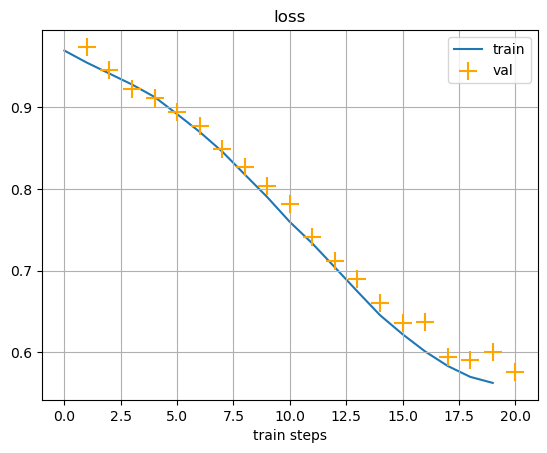

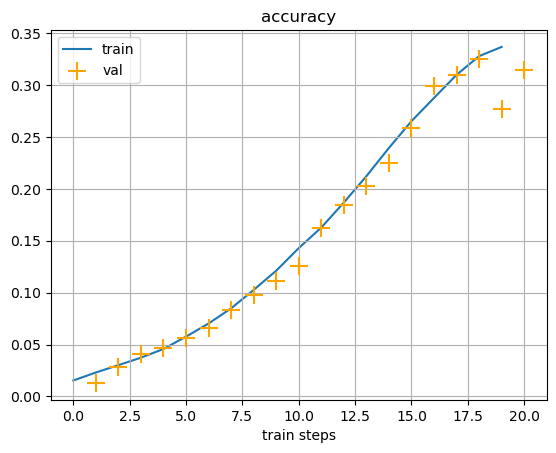

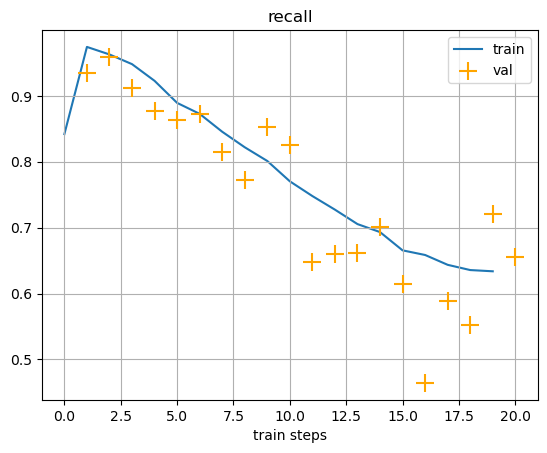

In [10]:
# графики процесса обучения
plot_history(summary['loss_train'], summary['loss_test'])
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [11]:
torch.cuda.empty_cache()

STAGE 2
Второй этап обучения, увеличиваем размерность до 1024х1024

In [12]:
size = 1024
train_list = [
        alb.LongestMaxSize(size, interpolation=cv2.INTER_AREA),
        alb.PadIfNeeded(size, size),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        ToTensorV2(transpose_mask=True),
    ]
eval_list = [
        alb.LongestMaxSize(size, interpolation=cv2.INTER_AREA),
        alb.PadIfNeeded(size, size),
        ToTensorV2(transpose_mask=True)
    ]

transforms = {'train': alb.Compose(train_list), 'test': alb.Compose(eval_list)}
dataset = EyeDataset("ds/train")
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25, random_state=42)
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    6,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    6,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

In [14]:
# Загрузка предыдущего этапа
model = torch.load('models/stage1.pth')
criterion = make_criterion()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())

In [15]:
# 2й этап обучения
summary = trainer.fit(train_loader, 20, val_loader=valid_loader)
torch.save(model, 'models/stage2.pth')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

loss_train: 0.5055968761444092
dice_train: 0.49440312422352073
accuracy_train: 0.41540966394506856
recall_train: 0.6324466190956257
--------


  5%|████                                                                            | 1/20 [04:23<1:23:24, 263.39s/it]

loss_test: 0.5148032616685938
dice_test: 0.4851967283972987
accuracy_test: 0.5188841422398885
recall_test: 0.46357502650331567
--------
loss_train: 0.4760151262636538
dice_train: 0.5239848593870798
accuracy_train: 0.4633174063982787
recall_train: 0.6261535908704923
--------


 10%|████████                                                                        | 2/20 [08:46<1:18:57, 263.22s/it]

loss_test: 0.47803677011419227
dice_test: 0.5219632343009666
accuracy_test: 0.4896705774245439
recall_test: 0.5795690097190715
--------
loss_train: 0.4633312630064694
dice_train: 0.5366687347859512
accuracy_train: 0.4806974046392205
recall_train: 0.6304692442034497
--------


 15%|████████████                                                                    | 3/20 [13:12<1:14:55, 264.42s/it]

loss_test: 0.46552263145093564
dice_test: 0.5344773608225363
accuracy_test: 0.505130797624588
recall_test: 0.5827937622865041
--------
loss_train: 0.4593970782962846
dice_train: 0.5406029202319957
accuracy_train: 0.4888794035823257
recall_train: 0.6299402272259748
--------


 20%|████████████████                                                                | 4/20 [17:37<1:10:32, 264.54s/it]

loss_test: 0.4541407757335239
dice_test: 0.5458592176437378
accuracy_test: 0.5227123278158682
recall_test: 0.5953408203743122
--------
loss_train: 0.4496370988127626
dice_train: 0.550362894564499
accuracy_train: 0.5022152150854652
recall_train: 0.6277985399887885
--------


 25%|████████████████████                                                            | 5/20 [22:01<1:06:07, 264.48s/it]

loss_test: 0.459161051997432
dice_test: 0.5408389524177268
accuracy_test: 0.5346021177592101
recall_test: 0.5625350883713475
--------
loss_train: 0.44748617469528573
dice_train: 0.5525138242009245
accuracy_train: 0.5083420335510631
recall_train: 0.6292053402206044
--------


 30%|████████████████████████                                                        | 6/20 [26:24<1:01:34, 263.86s/it]

loss_test: 0.456187438081812
dice_test: 0.5438125442575525
accuracy_test: 0.468151996533076
recall_test: 0.6666404086130636
--------
loss_train: 0.44364594603762214
dice_train: 0.5563540546982376
accuracy_train: 0.5106599857041865
recall_train: 0.626124972914472
--------


 35%|████████████████████████████▋                                                     | 7/20 [30:48<57:13, 264.09s/it]

loss_test: 0.44860960598345156
dice_test: 0.5513903973279176
accuracy_test: 0.5288598901695676
recall_test: 0.5924380035312088
--------
loss_train: 0.4399864187947026
dice_train: 0.5600135881959656
accuracy_train: 0.5190308226479424
recall_train: 0.6284303407610199
--------


 40%|████████████████████████████████▊                                                 | 8/20 [35:13<52:52, 264.41s/it]

loss_test: 0.4402656312342043
dice_test: 0.5597343687657956
accuracy_test: 0.5279500219557021
recall_test: 0.6092621043876365
--------
loss_train: 0.44051426207577743
dice_train: 0.5594857393959423
accuracy_train: 0.5135982956415341
recall_train: 0.6385248351244279
--------


 45%|████████████████████████████████████▉                                             | 9/20 [39:39<48:31, 264.71s/it]

loss_test: 0.4456163600639061
dice_test: 0.5543836344171453
accuracy_test: 0.5593158591676641
recall_test: 0.564341413754004
--------
loss_train: 0.43793714487994156
dice_train: 0.5620628444500911
accuracy_train: 0.5219635393148587
recall_train: 0.6318884363145004
--------


 50%|████████████████████████████████████████▌                                        | 10/20 [44:03<44:07, 264.70s/it]

loss_test: 0.4351109994782342
dice_test: 0.564888988380079
accuracy_test: 0.5146596255125823
recall_test: 0.6401189852643896
--------
loss_train: 0.43549422128700915
dice_train: 0.5645057772412713
accuracy_train: 0.5286574566069945
recall_train: 0.6289240103444935
--------


 55%|████████████████████████████████████████████▌                                    | 11/20 [48:28<39:43, 264.81s/it]

loss_test: 0.4360268336755258
dice_test: 0.5639731652206845
accuracy_test: 0.5121742442802146
recall_test: 0.6519772266900098
--------
loss_train: 0.4312787828622041
dice_train: 0.5687212072036885
accuracy_train: 0.526274972859724
recall_train: 0.6363302248495596
--------


 60%|████████████████████████████████████████████████▌                                | 12/20 [52:53<35:16, 264.62s/it]

loss_test: 0.43001922633912826
dice_test: 0.5699807615191849
accuracy_test: 0.5477026800314585
recall_test: 0.6101269114900518
--------
loss_train: 0.427139276339684
dice_train: 0.5728607122544889
accuracy_train: 0.5326071274869236
recall_train: 0.6397824868743802
--------


 65%|████████████████████████████████████████████████████▋                            | 13/20 [57:17<30:51, 264.46s/it]

loss_test: 0.43495671616660225
dice_test: 0.56504327500308
accuracy_test: 0.5144942193119614
recall_test: 0.6477139238958005
--------
loss_train: 0.42528213247840785
dice_train: 0.5747178752481201
accuracy_train: 0.5405021990522926
recall_train: 0.63141969287837
--------


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:01:41<26:26, 264.41s/it]

loss_test: 0.4443675919815346
dice_test: 0.5556324267828906
accuracy_test: 0.5348921351962619
recall_test: 0.5923339879071271
--------
loss_train: 0.4204053775763806
dice_train: 0.5795946187443204
accuracy_train: 0.5381516998196826
recall_train: 0.6480093234115176
--------


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:06:05<22:00, 264.16s/it]

loss_test: 0.430733272322902
dice_test: 0.5692667133278317
accuracy_test: 0.5614588989151849
recall_test: 0.5882253050804138
--------
loss_train: 0.41990821597016886
dice_train: 0.5800917832939713
accuracy_train: 0.5417170874130579
recall_train: 0.6402019288068936
--------


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:10:29<17:36, 264.13s/it]

loss_test: 0.43223603787245574
dice_test: 0.5677639610237546
accuracy_test: 0.5092408977172993
recall_test: 0.6589690446853638
--------
loss_train: 0.4126682266776944
dice_train: 0.5873317766336748
accuracy_train: 0.5479635824391871
recall_train: 0.6493865111727773
--------


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:14:52<13:11, 263.95s/it]

loss_test: 0.4344819894543401
dice_test: 0.5655180127532394
accuracy_test: 0.5331500812813088
recall_test: 0.6228085977059824
--------
loss_train: 0.41758612276595314
dice_train: 0.5824138787057664
accuracy_train: 0.5446396547335165
recall_train: 0.6436669160554438
--------


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:19:17<08:48, 264.11s/it]

loss_test: 0.4343617801313047
dice_test: 0.5656382275952233
accuracy_test: 0.5477276212639279
recall_test: 0.6028101642926534
--------
loss_train: 0.41229141126444313
dice_train: 0.5877085821128186
accuracy_train: 0.5497858870176622
recall_train: 0.6461818232948398
--------


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:23:41<04:24, 264.24s/it]

loss_test: 0.4350877183455008
dice_test: 0.5649122827582889
accuracy_test: 0.5897431649543621
recall_test: 0.5591079305719446
--------
loss_train: 0.416657018808671
dice_train: 0.5833429830309785
accuracy_train: 0.5469403138131271
recall_train: 0.6481833314454114
--------


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:28:06<00:00, 264.32s/it]

loss_test: 0.4401846726735433
dice_test: 0.5598153284302464
accuracy_test: 0.5025709988894286
recall_test: 0.6573300692770216
--------


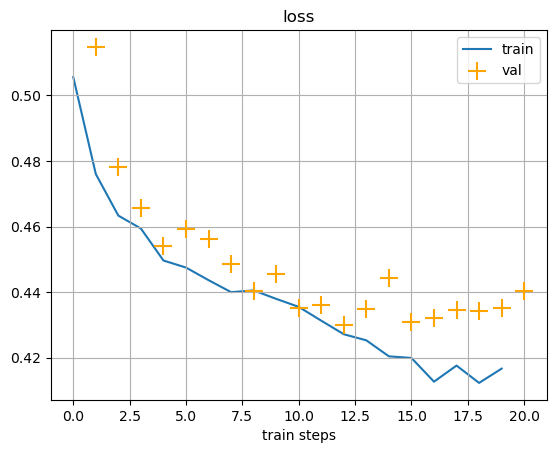

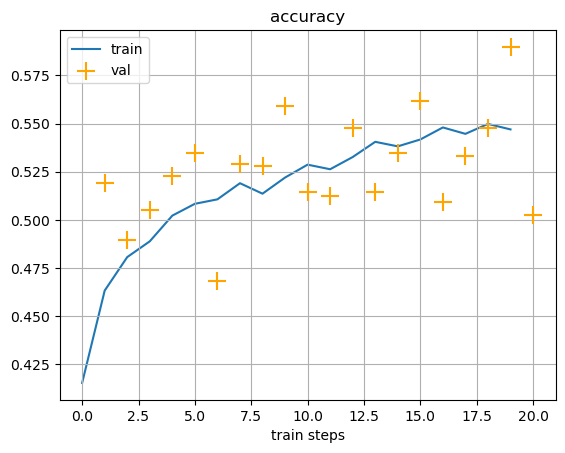

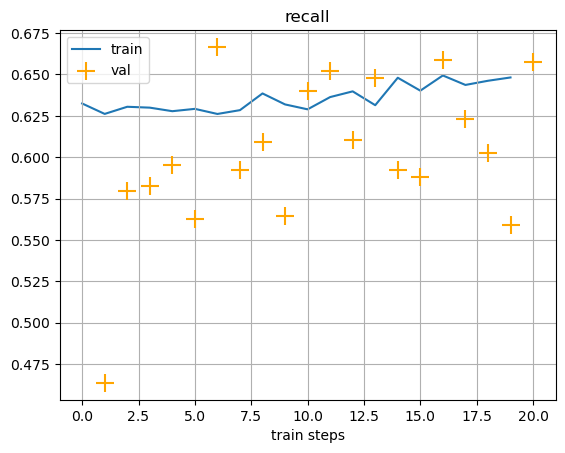

In [16]:
plot_history(summary['loss_train'], summary['loss_test'])
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [17]:
torch.cuda.empty_cache()

STAGE 2b
Дополнительный этап обучения с BCE-Dice Loss после повышения размерности

In [18]:
size = 1024
train_list = [
        alb.LongestMaxSize(size, interpolation=cv2.INTER_AREA),
        alb.PadIfNeeded(size, size),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        ToTensorV2(transpose_mask=True),
    ]
eval_list = [
        alb.LongestMaxSize(size, interpolation=cv2.INTER_AREA),
        alb.PadIfNeeded(size, size),
        ToTensorV2(transpose_mask=True)
    ]

transforms = {'train': alb.Compose(train_list), 'test': alb.Compose(eval_list)}
dataset = EyeDataset("ds/train")
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25, random_state=42)
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

In [19]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    6,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    6,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

In [20]:
# Загрузка предыдущего этапа
model = torch.load('models/stage2.pth')
criterion = make_bce_dice_criterion()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())

In [21]:
# этап обучения с BCE-Dice после повышения размерности
summary = trainer.fit(train_loader, 8, val_loader=valid_loader)
torch.save(model, 'models/stage2b.pth')

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

loss_train: 0.6521967649459839
dice_train: 0.39573181282590936
accuracy_train: 0.48568192933812554
recall_train: 0.37902390625741744
--------


 12%|██████████▍                                                                        | 1/8 [04:24<30:48, 264.12s/it]

loss_test: 0.5822220003163373
dice_test: 0.4623990367960047
accuracy_test: 0.4368258438728474
recall_test: 0.5061924004996264
--------
loss_train: 0.505392485194736
dice_train: 0.5291654765605927
accuracy_train: 0.4937180490405471
recall_train: 0.5875850857040028
--------


 25%|████████████████████▊                                                              | 2/8 [08:48<26:26, 264.33s/it]

loss_test: 0.532866773781953
dice_test: 0.511406601579101
accuracy_test: 0.4897836606811594
recall_test: 0.5536900670440109
--------
loss_train: 0.4757003706914407
dice_train: 0.558595750802829
accuracy_train: 0.5248485443032818
recall_train: 0.6132550909195418
--------


 38%|███████████████████████████████▏                                                   | 3/8 [13:12<22:01, 264.36s/it]

loss_test: 0.5209808791125262
dice_test: 0.525142839661351
accuracy_test: 0.5247671615194391
recall_test: 0.547792516372822
--------
loss_train: 0.4690507639337469
dice_train: 0.5660043285216814
accuracy_train: 0.5365599415920399
recall_train: 0.6164693593243022
--------


 50%|█████████████████████████████████████████▌                                         | 4/8 [17:37<17:37, 264.45s/it]

loss_test: 0.5145483557824735
dice_test: 0.5321043310342012
accuracy_test: 0.5392599823298277
recall_test: 0.5426681052755427
--------
loss_train: 0.45631381023077316
dice_train: 0.5790269073144889
accuracy_train: 0.5419178089977782
recall_train: 0.6358567785333704
--------


 62%|███████████████████████████████████████████████████▉                               | 5/8 [22:00<13:12, 264.03s/it]

loss_test: 0.519708577129576
dice_test: 0.528324838037844
accuracy_test: 0.5365848419842897
recall_test: 0.5398040502159683
--------
loss_train: 0.45076261589556565
dice_train: 0.585181975438271
accuracy_train: 0.5538818950270429
recall_train: 0.6339100452116978
--------


 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [26:26<08:49, 264.69s/it]

loss_test: 0.5078270082120542
dice_test: 0.5405186204998581
accuracy_test: 0.5351110487072556
recall_test: 0.5634816134417499
--------
loss_train: 0.447153267669089
dice_train: 0.5880678255616882
accuracy_train: 0.5600373178352545
recall_train: 0.6327532195014718
--------


 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [30:52<04:24, 264.88s/it]

loss_test: 0.5118195856059039
dice_test: 0.5370084544022878
accuracy_test: 0.5238307184643216
recall_test: 0.5728296781027759
--------
loss_train: 0.43981405687920844
dice_train: 0.5954355192773136
accuracy_train: 0.5615994794133269
recall_train: 0.6459193023634545
--------


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [35:15<00:00, 264.50s/it]

loss_test: 0.5145851318482999
dice_test: 0.53374602066146
accuracy_test: 0.5480430512516586
recall_test: 0.5431739080835272
--------


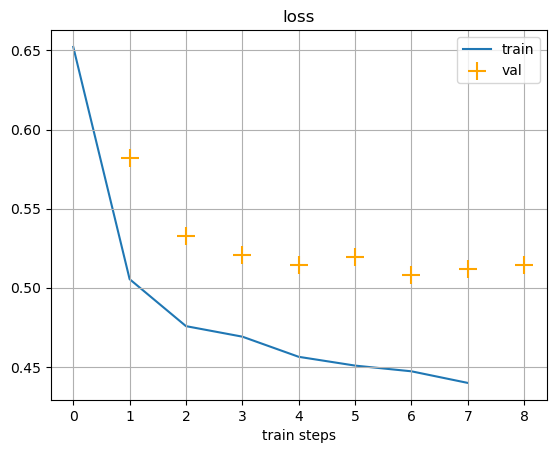

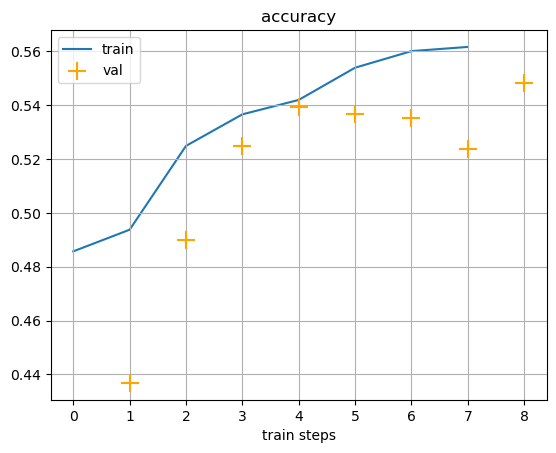

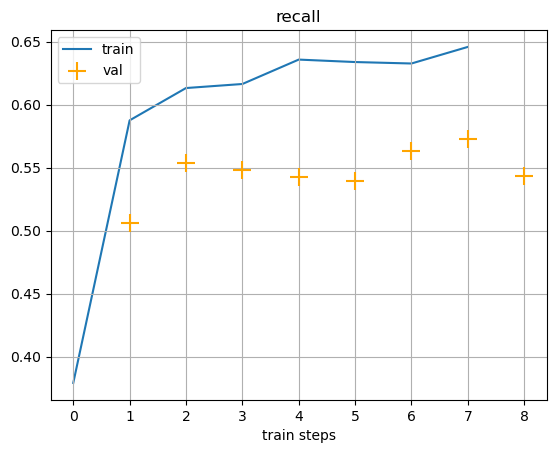

In [22]:
plot_history(summary['loss_train'], summary['loss_test'])
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [23]:
torch.cuda.empty_cache()

STAGE 3
Третий этап обучения, используем изображения датасета в полном разрешении.

In [24]:
size = 1632
train_list = [
        alb.PadIfNeeded(size, size),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        ToTensorV2(transpose_mask=True),
    ]
eval_list = [
        alb.PadIfNeeded(size, size),
        ToTensorV2(transpose_mask=True)
    ]

transforms = {'train': alb.Compose(train_list), 'test': alb.Compose(eval_list)}

dataset = EyeDataset("ds/train")
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25, random_state=42)
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

In [25]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    2,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    2,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

In [26]:
# Загрузка предыдущего этапа
model = torch.load('models/stage2b.pth')
criterion = make_criterion()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())

In [27]:
summary = trainer.fit(train_loader, 20, val_loader=valid_loader)
torch.save(model, 'models/stage3.pth')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

loss_train: 0.40663066286532606
dice_train: 0.5933693422645819
accuracy_train: 0.5883533662704171
recall_train: 0.6593949504074503
--------


  5%|████                                                                            | 1/20 [06:21<2:00:53, 381.76s/it]

loss_test: 0.3872718788959362
dice_test: 0.6127281255192227
accuracy_test: 0.5482765638533934
recall_test: 0.7434721728901804
--------
loss_train: 0.39263420955079503
dice_train: 0.6073657884949544
accuracy_train: 0.6012609443764706
recall_train: 0.6669564997685737
--------


 10%|████████                                                                        | 2/20 [12:43<1:54:33, 381.84s/it]

loss_test: 0.38108657392454737
dice_test: 0.6189134257075227
accuracy_test: 0.644301622370143
recall_test: 0.6254876024193234
--------
loss_train: 0.3870800345158968
dice_train: 0.6129199694231396
accuracy_train: 0.6048351704433071
recall_train: 0.6707153834524702
--------


 15%|████████████                                                                    | 3/20 [19:06<1:48:16, 382.14s/it]

loss_test: 0.387610274332541
dice_test: 0.6123897308184777
accuracy_test: 0.571259985551422
recall_test: 0.7028024560875363
--------
loss_train: 0.3914283848688251
dice_train: 0.6085716137876276
accuracy_train: 0.59971886552626
recall_train: 0.6630346540544854
--------


 20%|████████████████                                                                | 4/20 [25:30<1:42:05, 382.86s/it]

loss_test: 0.37963006452277853
dice_test: 0.6203699270148336
accuracy_test: 0.6694516035509698
recall_test: 0.6079843220887361
--------
loss_train: 0.3855897232157285
dice_train: 0.6144102794408309
accuracy_train: 0.607368964701891
recall_train: 0.6699865655820878
--------


 25%|████████████████████                                                            | 5/20 [31:54<1:35:52, 383.53s/it]

loss_test: 0.3891364887908653
dice_test: 0.6108635229828917
accuracy_test: 0.5817854662000397
recall_test: 0.6985074885097551
--------
loss_train: 0.38743171877548344
dice_train: 0.6125682912400512
accuracy_train: 0.6027686560801306
recall_train: 0.6731441907706808
--------


 30%|████████████████████████                                                        | 6/20 [38:19<1:29:33, 383.83s/it]

loss_test: 0.38508951590384966
dice_test: 0.6149104943981877
accuracy_test: 0.6643766181336509
recall_test: 0.6130054357611103
--------
loss_train: 0.3856998537896109
dice_train: 0.6143001543327433
accuracy_train: 0.6068377139993378
recall_train: 0.6778581822749044
--------


 35%|████████████████████████████                                                    | 7/20 [44:44<1:23:14, 384.18s/it]

loss_test: 0.3855350473780691
dice_test: 0.6144649511502113
accuracy_test: 0.5966911737197711
recall_test: 0.700038915431058
--------
loss_train: 0.38872906150387937
dice_train: 0.611270933976916
accuracy_train: 0.602783737551482
recall_train: 0.6744872845831464
--------


 40%|████████████████████████████████                                                | 8/20 [51:09<1:16:55, 384.61s/it]

loss_test: 0.37899261124340106
dice_test: 0.6210073999784611
accuracy_test: 0.6068681066418872
recall_test: 0.686752023888223
--------
loss_train: 0.38616449446951756
dice_train: 0.6138355028939617
accuracy_train: 0.6102233535231313
recall_train: 0.6751165047410081
--------


 45%|████████████████████████████████████                                            | 9/20 [57:34<1:10:32, 384.79s/it]

loss_test: 0.37658612890008053
dice_test: 0.6234138773547279
accuracy_test: 0.6395257177912159
recall_test: 0.6506419202059875
--------
loss_train: 0.38084118947631024
dice_train: 0.6191588039891641
accuracy_train: 0.6127166256430696
recall_train: 0.6774492175852667
--------


 50%|██████████████████████████████████████▌                                      | 10/20 [1:03:59<1:04:06, 384.62s/it]

loss_test: 0.3742916922510406
dice_test: 0.6257083268813145
accuracy_test: 0.6147292949903158
recall_test: 0.6845610450815272
--------
loss_train: 0.38355548606544243
dice_train: 0.6164445113085333
accuracy_train: 0.6049468054084993
recall_train: 0.6835441964327312
--------


 55%|███████████████████████████████████████████▍                                   | 11/20 [1:10:26<57:47, 385.32s/it]

loss_test: 0.39574071728152993
dice_test: 0.6042592963318766
accuracy_test: 0.6695512766823356
recall_test: 0.5924457304271651
--------
loss_train: 0.38588427056054597
dice_train: 0.6141157217445921
accuracy_train: 0.6086946254993071
recall_train: 0.671591044937978
--------


 60%|███████████████████████████████████████████████▍                               | 12/20 [1:16:52<51:24, 385.53s/it]

loss_test: 0.38866376288143206
dice_test: 0.6113362568028179
accuracy_test: 0.621455950225577
recall_test: 0.6452427138516932
--------
loss_train: 0.37733434653673015
dice_train: 0.6226656483333619
accuracy_train: 0.6143188701301324
recall_train: 0.6790932471879193
--------


 65%|███████████████████████████████████████████████████▎                           | 13/20 [1:23:19<45:03, 386.15s/it]

loss_test: 0.37792285724922464
dice_test: 0.6220771589396913
accuracy_test: 0.6465044400574248
recall_test: 0.6439187946142974
--------
loss_train: 0.38304414465779163
dice_train: 0.616955853998661
accuracy_train: 0.6116520596790265
recall_train: 0.6740925908088684
--------


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:29:46<38:37, 386.30s/it]

loss_test: 0.3762736710501306
dice_test: 0.6237263333650283
accuracy_test: 0.6200794807554763
recall_test: 0.678741823008031
--------
loss_train: 0.37600389953519475
dice_train: 0.623996096922726
accuracy_train: 0.6153272832820161
recall_train: 0.6840323779243426
--------


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:36:10<32:09, 385.82s/it]

loss_test: 0.37696732488679296
dice_test: 0.6230326758490669
accuracy_test: 0.6603384647104475
recall_test: 0.636571369421335
--------
loss_train: 0.3775969919611196
dice_train: 0.6224029968019391
accuracy_train: 0.6150795494618474
recall_train: 0.6820828205005067
--------


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:42:38<25:45, 386.36s/it]

loss_test: 0.3767981102437149
dice_test: 0.6232018665767011
accuracy_test: 0.6683733901123942
recall_test: 0.625495101198738
--------
loss_train: 0.37568002719371046
dice_train: 0.6243199619357703
accuracy_train: 0.6145860274917767
recall_train: 0.6798838806934044
--------


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:49:05<19:19, 386.47s/it]

loss_test: 0.40717691624606095
dice_test: 0.5928230763953409
accuracy_test: 0.7148327763065879
recall_test: 0.5384677865622957
--------
loss_train: 0.3734077129696236
dice_train: 0.6265922793660497
accuracy_train: 0.622092799619451
recall_train: 0.6836151121581187
--------


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:55:32<12:53, 386.80s/it]

loss_test: 0.3861157739603961
dice_test: 0.6138842076431086
accuracy_test: 0.5665485965616909
recall_test: 0.7229255573985017
--------
loss_train: 0.37392607868694866
dice_train: 0.6260739129464157
accuracy_train: 0.6144842249264971
recall_train: 0.6881893021894283
--------


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [2:02:00<06:26, 386.98s/it]

loss_test: 0.41379378975173575
dice_test: 0.5862062052812105
accuracy_test: 0.6919799331161711
recall_test: 0.5475329486308275
--------
loss_train: 0.3776857591554767
dice_train: 0.6223142263097842
accuracy_train: 0.6202096927559889
recall_train: 0.6803663143979721
--------


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:08:27<00:00, 385.35s/it]

loss_test: 0.38337363210725195
dice_test: 0.6166263693644677
accuracy_test: 0.6364038082552544
recall_test: 0.6416672045066033
--------


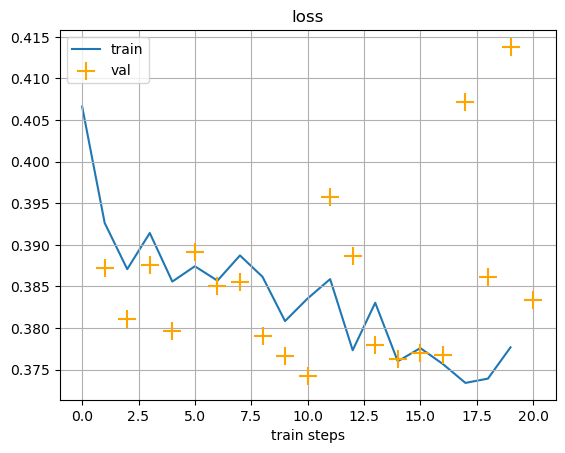

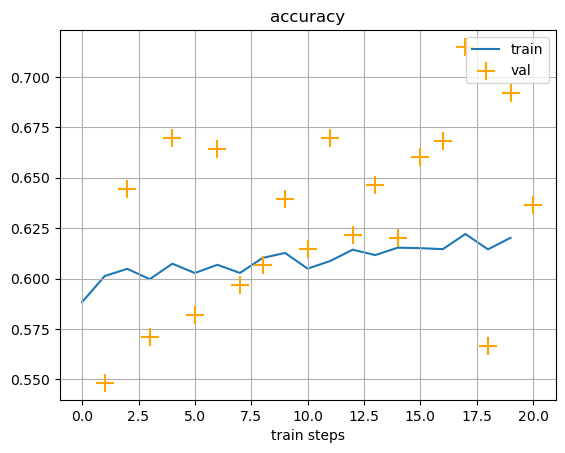

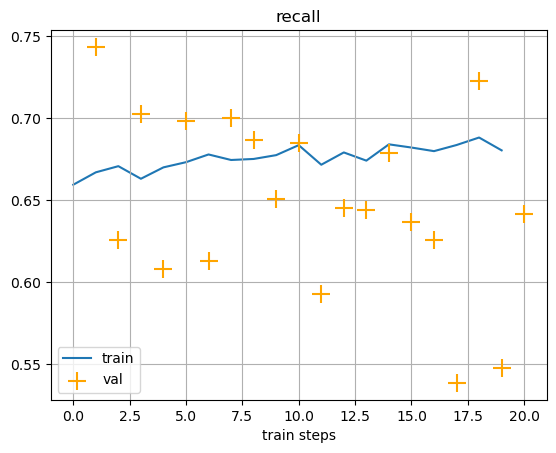

In [28]:
plot_history(summary['loss_train'], summary['loss_test'])
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [34]:
torch.cuda.empty_cache()

STAGE 3b
Дополнительный этап обучения с BCE-Dice Loss после повышения размерности

In [3]:
size = 1632
train_list = [
        alb.PadIfNeeded(size, size),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        ToTensorV2(transpose_mask=True),
    ]
eval_list = [
        alb.PadIfNeeded(size, size),
        ToTensorV2(transpose_mask=True)
    ]

transforms = {'train': alb.Compose(train_list), 'test': alb.Compose(eval_list)}

dataset = EyeDataset("ds/train")
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25, random_state=42)
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    2,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    2,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

In [5]:
# Загрузка предыдущего этапа
model = torch.load('models/stage3.pth')
criterion = make_bce_dice_criterion()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())

In [6]:
summary = trainer.fit(train_loader, 8, val_loader=valid_loader)
torch.save(model, 'models/stage3b.pth')

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

loss_train: 0.8385835650270103
dice_train: 0.2426284640755437
accuracy_train: 0.4138890760683561
recall_train: 0.24939483870678145
--------


 12%|██████████▍                                                                        | 1/8 [06:27<45:09, 387.06s/it]

loss_test: 0.5165417937584865
dice_test: 0.5249096431114055
accuracy_test: 0.5218850548988507
recall_test: 0.5709940158290627
--------
loss_train: 0.5178885270581871
dice_train: 0.5201010025243779
accuracy_train: 0.5489278862436042
recall_train: 0.5543415048235997
--------


 25%|████████████████████▊                                                              | 2/8 [12:51<38:32, 385.47s/it]

loss_test: 0.5530463273142591
dice_test: 0.5025472863588805
accuracy_test: 0.47178072325977277
recall_test: 0.5833362258142896
--------
loss_train: 0.4945586803750914
dice_train: 0.5451737587019557
accuracy_train: 0.5491065237610067
recall_train: 0.5960751840325652
--------


 38%|███████████████████████████████▏                                                   | 3/8 [19:17<32:09, 385.93s/it]

loss_test: 0.4493819931407034
dice_test: 0.5890554734218267
accuracy_test: 0.6010904823556359
recall_test: 0.6074996130701936
--------
loss_train: 0.4764131008357298
dice_train: 0.5590850377272143
accuracy_train: 0.5737553684224115
recall_train: 0.5966823738617976
--------


 50%|█████████████████████████████████████████▌                                         | 4/8 [25:43<25:43, 385.89s/it]

loss_test: 0.4749708061600909
dice_test: 0.5652855631010032
accuracy_test: 0.6319723375785498
recall_test: 0.5482139110933115
--------
loss_train: 0.47960790808572146
dice_train: 0.5556976566793489
accuracy_train: 0.5660228147247776
recall_train: 0.593516861195447
--------


 62%|███████████████████████████████████████████████████▉                               | 5/8 [32:11<19:19, 386.44s/it]

loss_test: 0.4736080077695258
dice_test: 0.5661518110169305
accuracy_test: 0.5799530694882075
recall_test: 0.6089890698591868
--------
loss_train: 0.5639972663560852
dice_train: 0.47681298048891985
accuracy_train: 0.4998419853080003
recall_train: 0.5024628659374402
--------


 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [38:37<12:52, 386.32s/it]

loss_test: 0.5636650493115555
dice_test: 0.47508697782033754
accuracy_test: 0.5285750084821089
recall_test: 0.46594309328514855
--------
loss_train: 0.5743569146658554
dice_train: 0.4651797627037788
accuracy_train: 0.4862149362223315
recall_train: 0.49865451946732453
--------


 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [45:03<06:26, 386.36s/it]

loss_test: 0.8428391461019162
dice_test: 0.21283332782763023
accuracy_test: 0.4039581015154167
recall_test: 0.15253736901982332
--------
loss_train: 0.6627613401315251
dice_train: 0.38378380898569453
accuracy_train: 0.3754924506437583
recall_train: 0.43828024751827366
--------


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [51:30<00:00, 386.37s/it]

loss_test: 0.6014452878339791
dice_test: 0.45068740329624696
accuracy_test: 0.49319477011392143
recall_test: 0.4469911800122555
--------


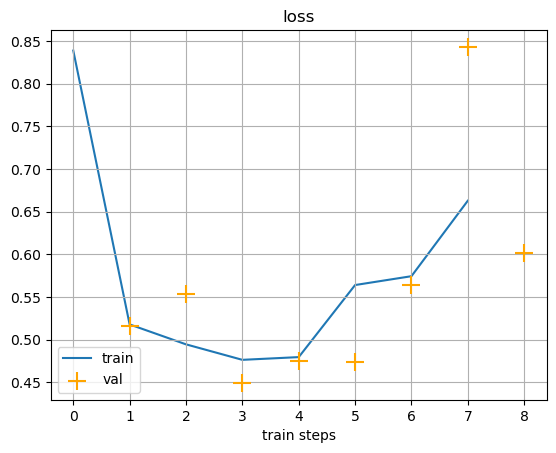

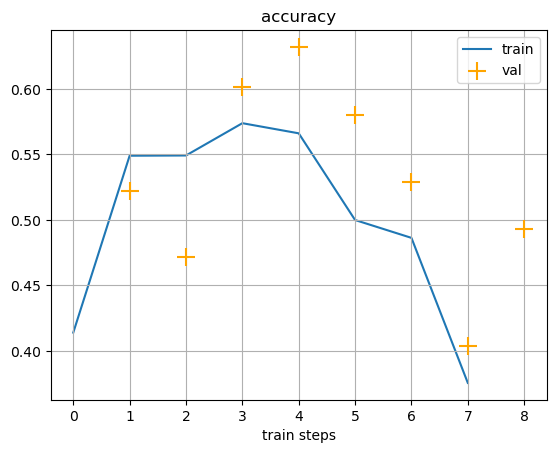

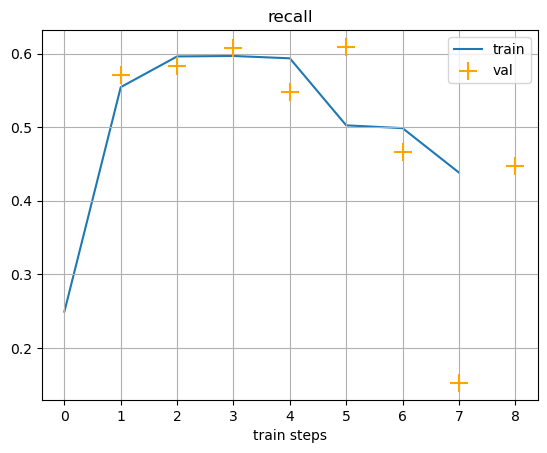

In [9]:
plot_history(summary['loss_train'], summary['loss_test'])
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [10]:
torch.cuda.empty_cache()

STAGE 4
Финальный этап обучения, "полировка" модели с использованием низкой скорости оптимизатора.

In [11]:
size = 1632
train_list = [
        alb.PadIfNeeded(size, size),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        ToTensorV2(transpose_mask=True),
    ]
eval_list = [
        alb.PadIfNeeded(size, size),
        ToTensorV2(transpose_mask=True)
    ]

transforms = {'train': alb.Compose(train_list), 'test': alb.Compose(eval_list)}

dataset = EyeDataset("ds/train")
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25, random_state=42)
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

In [12]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    2,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    2,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

In [13]:
# Загрузка предыдущего этапа
#model = torch.load('models/stage3b.pth')
criterion = make_criterion()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())

In [14]:
summary = trainer.fit(train_loader, 20, val_loader=valid_loader)
torch.save(model, 'models/stage4.pth')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

loss_train: 0.4957051475028523
dice_train: 0.5042948555506643
accuracy_train: 0.4916197120776919
recall_train: 0.571710497263025
--------


  5%|████                                                                            | 1/20 [06:22<2:01:12, 382.78s/it]

loss_test: 0.4399122382387703
dice_test: 0.560087768383968
accuracy_test: 0.5870380311468502
recall_test: 0.5776868683320505
--------
loss_train: 0.44280919505924476
dice_train: 0.5571908058568102
accuracy_train: 0.5459015168493888
recall_train: 0.6221125802544297
--------


 10%|████████                                                                        | 2/20 [12:48<1:55:17, 384.29s/it]

loss_test: 0.41271483677404897
dice_test: 0.5872851610183716
accuracy_test: 0.588039176515591
recall_test: 0.6244807964489784
--------
loss_train: 0.42507948225638903
dice_train: 0.574920515361868
accuracy_train: 0.5691106309350885
recall_train: 0.6312553533887277
--------


 15%|████████████                                                                    | 3/20 [19:12<1:48:57, 384.55s/it]

loss_test: 0.4176605387970253
dice_test: 0.5823394582595354
accuracy_test: 0.6104678796765245
recall_test: 0.6023570330422602
--------
loss_train: 0.41336693016232035
dice_train: 0.5866330755782909
accuracy_train: 0.5869603614154898
recall_train: 0.6355474867293092
--------


 20%|████████████████                                                                | 4/20 [25:39<1:42:42, 385.17s/it]

loss_test: 0.39810899599098865
dice_test: 0.6018910030891866
accuracy_test: 0.6169445785107436
recall_test: 0.6330500230377103
--------
loss_train: 0.4116035541061495
dice_train: 0.5883964521230244
accuracy_train: 0.5875003153122351
recall_train: 0.6474095962819506
--------


 25%|████████████████████                                                            | 5/20 [32:04<1:36:16, 385.13s/it]

loss_test: 0.39500591563589776
dice_test: 0.6049940856518569
accuracy_test: 0.6071210475983443
recall_test: 0.6458944325093869
--------
loss_train: 0.4088519469636386
dice_train: 0.5911480550516824
accuracy_train: 0.58820505804367
recall_train: 0.6525955763263781
--------


 30%|████████████████████████                                                        | 6/20 [38:29<1:29:51, 385.14s/it]

loss_test: 0.39761658288814405
dice_test: 0.6023834134325569
accuracy_test: 0.6203959817871635
recall_test: 0.6276967481330589
--------
loss_train: 0.3980686820921351
dice_train: 0.6019313249920235
accuracy_train: 0.5958337212195162
recall_train: 0.6530631326261114
--------


 35%|████████████████████████████                                                    | 7/20 [44:55<1:23:31, 385.48s/it]

loss_test: 0.3933261471030153
dice_test: 0.6066738598876529
accuracy_test: 0.6373136288221971
recall_test: 0.623648214487382
--------
loss_train: 0.3933462187892101
dice_train: 0.6066537944019817
accuracy_train: 0.6028585452586412
recall_train: 0.6605083757980925
--------


 40%|████████████████████████████████                                                | 8/20 [51:21<1:17:08, 385.70s/it]

loss_test: 0.3923253012292179
dice_test: 0.6076747098086793
accuracy_test: 0.6545521215892133
recall_test: 0.6052288994377042
--------
loss_train: 0.39174505359813816
dice_train: 0.6082549535165556
accuracy_train: 0.6019828459705974
recall_train: 0.6671092368540217
--------


 45%|████████████████████████████████████                                            | 9/20 [57:47<1:10:42, 385.73s/it]

loss_test: 0.38974824290216703
dice_test: 0.6102517651922909
accuracy_test: 0.6394023457427084
recall_test: 0.6313402075090526
--------
loss_train: 0.38877858685665445
dice_train: 0.611221427998704
accuracy_train: 0.6073635256482808
recall_train: 0.6638320829169672
--------


 50%|██████████████████████████████████████▌                                      | 10/20 [1:04:13<1:04:18, 385.87s/it]

loss_test: 0.39850862085083383
dice_test: 0.6014913728943577
accuracy_test: 0.6548601376053728
recall_test: 0.5926230590284607
--------
loss_train: 0.3849646214578972
dice_train: 0.6150353873362306
accuracy_train: 0.6135835845450885
recall_train: 0.6634501552239793
--------


 55%|███████████████████████████████████████████▍                                   | 11/20 [1:10:40<57:55, 386.17s/it]

loss_test: 0.3919626908537782
dice_test: 0.6080373257030676
accuracy_test: 0.6211564535344088
recall_test: 0.6431985359500956
--------
loss_train: 0.3856004508303814
dice_train: 0.6143995603073205
accuracy_train: 0.6100455996614774
recall_train: 0.6759035371121813
--------


 60%|███████████████████████████████████████████████▍                               | 12/20 [1:17:07<51:30, 386.32s/it]

loss_test: 0.3940532479757144
dice_test: 0.6059467645339024
accuracy_test: 0.64811623354017
recall_test: 0.6140011548995972
--------
loss_train: 0.37898085962553496
dice_train: 0.6210191473250323
accuracy_train: 0.6156240077269431
recall_train: 0.6683031640580444
--------


 65%|███████████████████████████████████████████████████▎                           | 13/20 [1:23:33<45:04, 386.34s/it]

loss_test: 0.3862005155763508
dice_test: 0.6137994925181071
accuracy_test: 0.6395875171378806
recall_test: 0.6296617020795374
--------
loss_train: 0.3812715474699364
dice_train: 0.6187284596447573
accuracy_train: 0.6111244625091309
recall_train: 0.6709317391066522
--------


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:30:01<38:41, 386.90s/it]

loss_test: 0.3902694075195878
dice_test: 0.6097305961597113
accuracy_test: 0.6108629250967944
recall_test: 0.6630752903443796
--------
loss_train: 0.3817778979657126
dice_train: 0.6182221186454179
accuracy_train: 0.613025553127537
recall_train: 0.6759063035982554
--------


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:36:28<32:14, 386.88s/it]

loss_test: 0.391671887886377
dice_test: 0.6083281145051673
accuracy_test: 0.6368666960869307
recall_test: 0.6241114794472118
--------
loss_train: 0.37467478924110287
dice_train: 0.6253252136292028
accuracy_train: 0.6132642353167299
recall_train: 0.6822094294379969
--------


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:42:54<25:46, 386.57s/it]

loss_test: 0.39483213424682617
dice_test: 0.6051678756872813
accuracy_test: 0.667032559344798
recall_test: 0.6057104056264148
--------
loss_train: 0.37430454033320065
dice_train: 0.6256954675448723
accuracy_train: 0.6217330595570021
recall_train: 0.6759013528706598
--------


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:49:20<19:19, 386.42s/it]

loss_test: 0.40412682074087636
dice_test: 0.5958731952640746
accuracy_test: 0.6667750514583823
recall_test: 0.5758458033755973
--------
loss_train: 0.37368332631275303
dice_train: 0.6263166862677355
accuracy_train: 0.6230261735618114
recall_train: 0.6801764123508187
--------


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:55:45<12:52, 386.09s/it]

loss_test: 0.3938176558341509
dice_test: 0.6061823568594309
accuracy_test: 0.6498033218545678
recall_test: 0.609067318432125
--------
loss_train: 0.3697354304985922
dice_train: 0.6302645730892898
accuracy_train: 0.6258128825193424
recall_train: 0.6821210955987211
--------


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [2:02:12<06:26, 386.32s/it]

loss_test: 0.39294602694334807
dice_test: 0.6070539826228295
accuracy_test: 0.6587088286508749
recall_test: 0.6007967480906734
--------
loss_train: 0.36401091222880316
dice_train: 0.6359890961989028
accuracy_train: 0.6282786672599003
recall_train: 0.6819218626764955
--------


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:08:37<00:00, 385.90s/it]

loss_test: 0.39101389087276694
dice_test: 0.6089861157499714
accuracy_test: 0.6239096417471215
recall_test: 0.650931164070412
--------


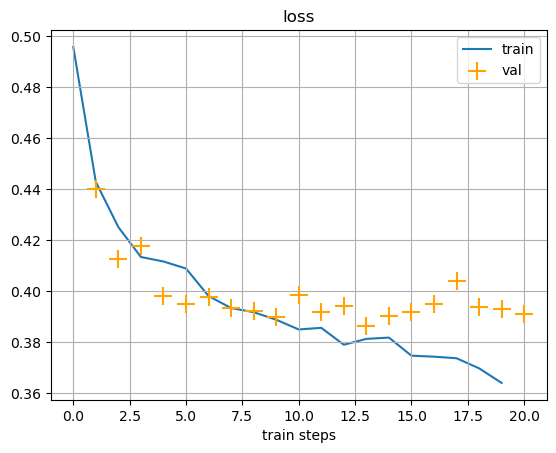

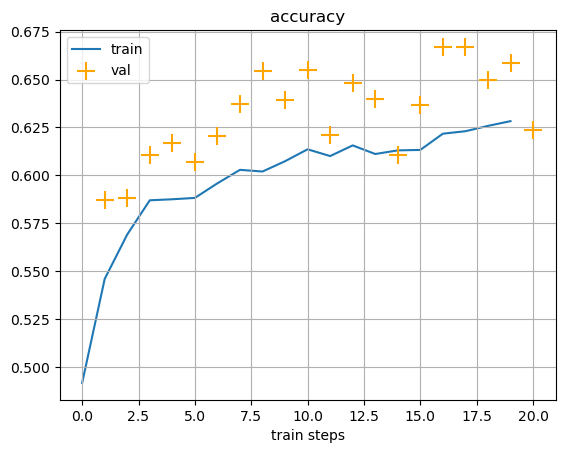

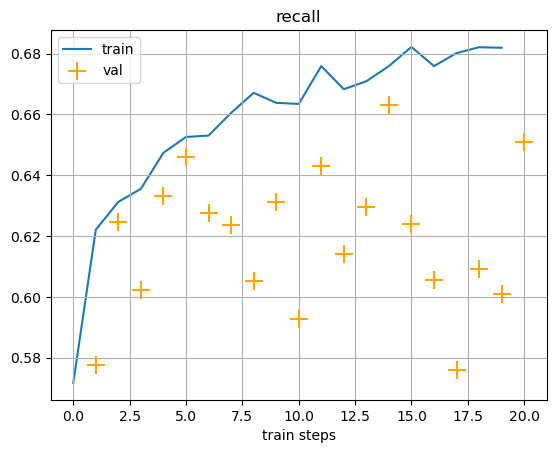

In [15]:
plot_history(summary['loss_train'], summary['loss_test'])
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [4]:
model = torch.load('cp815459_model.pth')

Протестируем работу модели

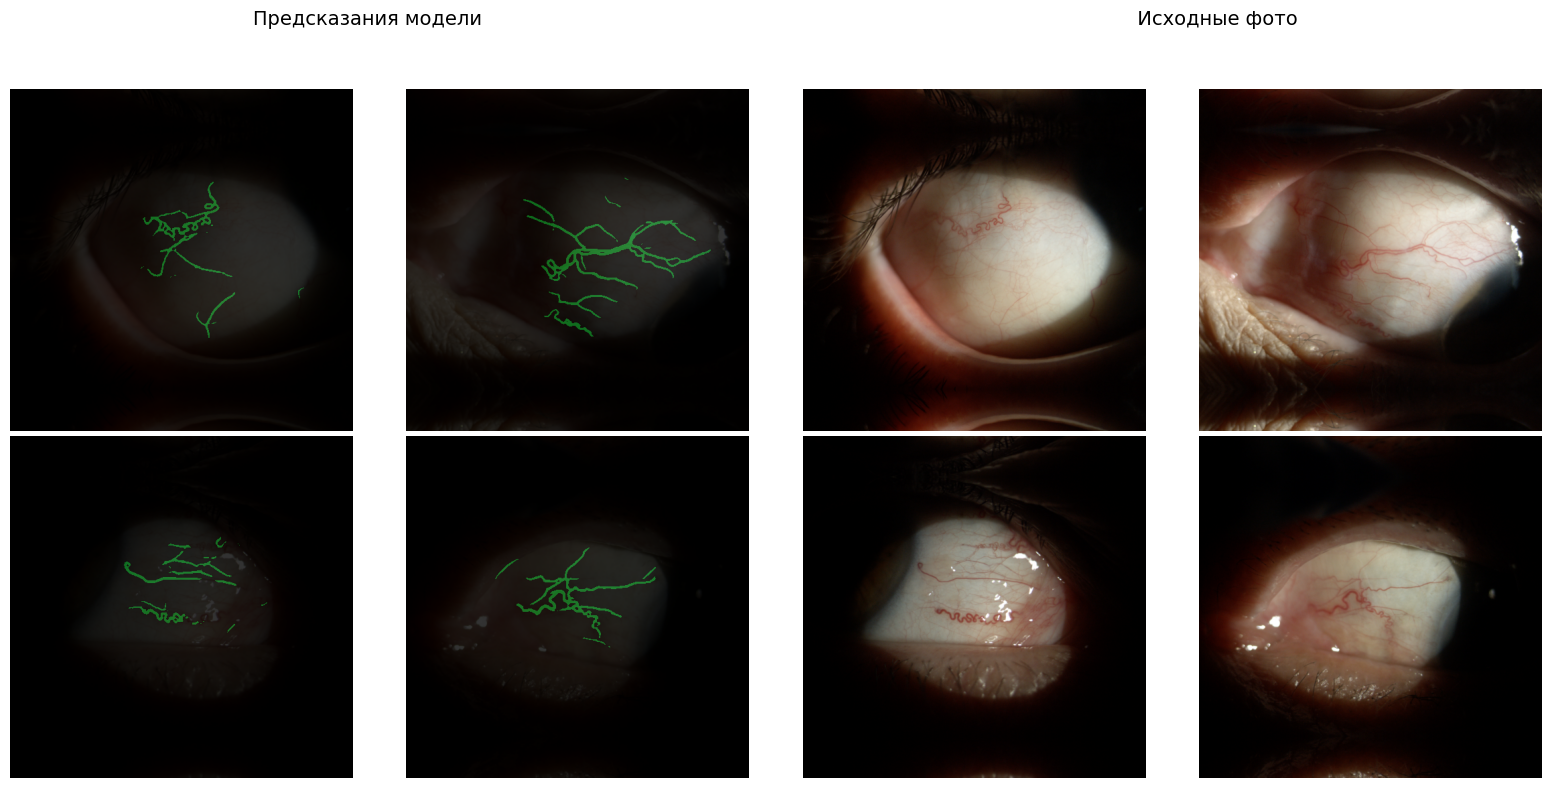

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предсказания модели {" "*105} Исходные фото', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to("cuda")
    true_mask = sample['mask'].to("cuda")

    prediction = model.eval()(image.unsqueeze(dim=0))

    image = (image.cpu() * 255).type(torch.uint8)
    pred_mask = (torch.exp(prediction[0]) > 0.5).cpu()

    image_with_mask = draw_segmentation_masks(image, pred_mask)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)    
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

сохраняем полученные маски

In [6]:
size = 1632
test_transform = [
        alb.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
        alb.PadIfNeeded(size, size),
        ToTensorV2(transpose_mask=True),
    ]

test_dataset = InferenceDataset("ds/test", transform=alb.Compose(test_transform))
output_transform = torchvision_transforms.Compose([torchvision_transforms.CenterCrop((1232, 1624)),])    

torch.cuda.empty_cache()
filenames = os.listdir("ds/test")

for i, s in enumerate(test_dataset):
    image = s['image'].to("cuda")
    predicted_mask = model.eval()(image.unsqueeze(dim=0))[0]
    predicted_mask = output_transform(predicted_mask)
    
    predicted_mask = (torch.exp(predicted_mask) > 0.5).cpu().detach().numpy()[1]
    Image.fromarray(predicted_mask).save(f"solution/{filenames[i]}")
    